In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error as mse

In [32]:
SAVE_FIGURES = True

## Simulation

In [53]:
d = 9
n = 8
beta1s = 3
n_runs = 50
beta = np.asarray([1]*beta1s + [0]*(d-beta1s))
std = 0.1
bayes_error = std**2

thresh = n

results_mat = []

for i in range(n_runs):
    np.random.seed(i)
    X_train = np.random.normal(0, 1, (n, d))
    y_train = X_train @ beta.T + np.random.normal(0, std, (n,))
    X_test = np.random.normal(0, 1, (10000, d))
    y_test = X_test @ beta.T + np.random.normal(0, std, (10000,))

    # OLS until interpolation
    for p in range(1, thresh+1):
        lr = LinearRegression(fit_intercept=False).fit(X_train[:, :p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, :p]))
        test_error = mse(y_test, lr.predict(X_test[:, :p]))
        alpha = 0
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (1 + p) * np.log(n)
        results_mat.append([
            i, 'OLS', p, train_error, test_error, alpha, bic
        ])
        results_mat.append([
            i, r'OLS $\rightarrow$ Ridge', p, train_error, test_error, alpha, bic
        ])

        results_mat.append([
            i, 'LS min norm', p, train_error, test_error, alpha, bic
        ])

    # Add ridge regression to OLS at interpolation
    for p in range(thresh, d):
        lr = RidgeCV(fit_intercept=False, scoring='neg_mean_squared_error', alphas=np.logspace(-2, 2, 20)).fit(X_train[:, :p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, :p]))
        test_error = mse(y_test, lr.predict(X_test[:, :p]))
        alpha = lr.alpha_
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (2 + p) * np.log(n)
        results_mat.append([
            i, r'OLS $\rightarrow$ Ridge', p, train_error, test_error, alpha, bic
        ])
        
    # OLS min norm past interpolation
    for p in range(thresh, d+1):
        lr = LinearRegression(fit_intercept=False).fit(X_train[:, :p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, :p]))
        test_error = mse(y_test, lr.predict(X_test[:, :p]))
        alpha = 0
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (1 + p) * np.log(n)
        results_mat.append([
            i, 'LS min norm', p, train_error, test_error, alpha, bic
        ])
        
    # OLS past interpolation
    for p in range(thresh, d+1):
        lr = LinearRegression(fit_intercept=False).fit(X_train[:, p-n:p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, p-n:p]))
        test_error = mse(y_test, lr.predict(X_test[:, p-n:p]))
        alpha = 0
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, p-n:p]))) + (1 + p) * np.log(n)
        results_mat.append([
            i, 'OLS', p, train_error, test_error, alpha, bic
        ])

    # Ridge regression the whole way
    for p in range(1, d):
        lr = RidgeCV(fit_intercept=False, scoring='neg_mean_squared_error', alphas=np.logspace(-2, 2, 20)).fit(X_train[:, :p], y_train)
        # lr = LassoCV(fit_intercept=False, alphas=np.logspace(-4, 4, 20)).fit(X_train[:, :p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, :p]))
        test_error = mse(y_test, lr.predict(X_test[:, :p]))
        alpha = lr.alpha_
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (2 + p) * np.log(n)
        results_mat.append([
            i, 'Ridge', p, train_error, test_error, alpha, bic
        ])
        
    # Best in class whole way
    for p in range(1, d+1):
        train_error = mse(y_train, np.sum(X_train[:, :min(p, 3)], axis=1))
        test_error = mse(y_test, np.sum(X_test[:, :min(p, 3)], axis=1))
        alpha = None
        bic = None
        results_mat.append([
            i, 'Best in class', p, train_error, test_error, alpha, bic
        ])

df = pd.DataFrame(
    results_mat,
    columns=['rep', 'Method', 'Number of features', 'Train MSE', 'Test MSE', 'L2 penalty', 'BIC']
)
df['Number of model parameters'] = df['Number of features'] + (df['L2 penalty'] > 0)
df['Generalization gap'] = df['Test MSE'] - df['Train MSE']


## Scatterplot

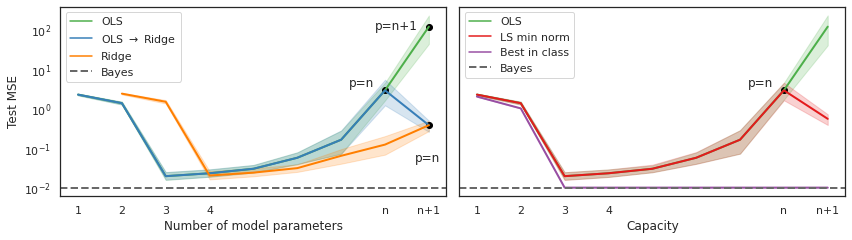

In [55]:
sns.set_style('white')
sns.set_context('notebook')
# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['ytick.left'] = True

y_var = 'Test MSE'

f, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=True)

ax = axes[0]
sns.lineplot(
    data = df,
#     data=df[
#         df['Method'].isin(['OLS', r'OLS $\rightarrow$ Ridge', 'Ridge', 'OLS (min norm)', 'Best in class'])
#     ],
    x='Number of model parameters',
    y=y_var,
    ax=ax,
    linewidth=2,
    hue='Method',
    hue_order=['OLS', r'OLS $\rightarrow$ Ridge', 'Ridge'],
    palette=['#4daf4a', '#377eb8', '#ff7f00'])

ax.scatter(8, df[(df['Method'] == 'OLS') & (df['Number of model parameters'] == 8)]['Test MSE'].mean(), c='black')
ax.text(0.78, 0.6, 'p=n', horizontalalignment='center', # c=ax.get_lines()[0].get_c(),
         verticalalignment='center', transform=ax.transAxes)

ax.scatter(9, df[(df['Method'] == 'OLS') & (df['Number of model parameters'] == 9)]['Test MSE'].mean(), c='black')
ax.text(0.87, 0.9, 'p=n+1', horizontalalignment='center', #c=ax.get_lines()[0].get_c(),
         verticalalignment='center', transform=ax.transAxes)#, fontsize=12)

ax.scatter(9, df[(df['Method'] == r'OLS $\rightarrow$ Ridge') & (df['Number of model parameters'] == 9)]['Test MSE'].mean(), c='black')
ax.text(0.95, 0.2, 'p=n', horizontalalignment='center', #c=ax.get_lines()[0].get_c(),
         verticalalignment='center', transform=ax.transAxes)#, fontsize=12)

ax.set_xlabel(r'Number of model parameters')

ax = axes[1]
sns.lineplot(
    data = df,
    x='Number of model parameters',
    y=y_var,
    ax=ax,
    linewidth=2,
    hue='Method',
    hue_order=['OLS', 'LS min norm', 'Best in class'],
    palette=['#4daf4a', '#e41a1c', '#984ea3'])

ax.set_xlabel(r'Capacity')

ax.scatter(8, df[(df['Method'] == 'OLS') & (df['Number of model parameters'] == 8)]['Test MSE'].mean(), c='black')
ax.text(0.78, 0.6, 'p=n', horizontalalignment='center', # c=ax.get_lines()[0].get_c(),
         verticalalignment='center', transform=ax.transAxes)

for ax in axes:
    ax.set_xticks([1, 2, 3, 4, n, n+1])
    ax.set_xticklabels([1, 2, 3, 4, 'n', 'n+1'])
    ax.legend(loc="upper left")
    ax.axhline(bayes_error, ls='--', label='Bayes', c='dimgrey', linewidth=2)
    ax.legend()

plt.yscale('log')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig('./figures/regression_double_descent.pdf')
plt.show()

NameError: name 'df_dd' is not defined

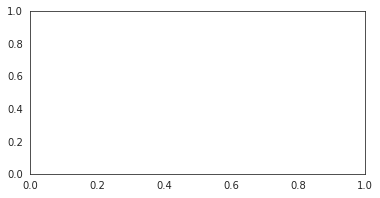

In [13]:
sns.set_style('white')
f, ax = plt.subplots(1, 1, figsize=(6, 3))

dd_errors = df[
    df['Method'] == 'OLS + Ridge'
]['Generalization MSE'].groupby(
    ['Number of model parameters']
).mean().reset_index().to_numpy()
sd_errors = df[
    df['Method'] == 'Ridge'
]['Generalization MSE'].groupby(
    ['Number of model parameters']
).mean().reset_index().to_numpy()
max_error = np.max(np.concatenate((dd_errors, sd_errors)))

n_params, errors, regs = df_dd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
n_params[-1] -= 1

ax.plot(regs, n_params, ls='-', c='blue', label='OLS', alpha=0.5)
sc = ax.scatter(
    regs, n_params, c=errors, vmax=max_error, vmin=min_error,#cm.Reds(np.log(errors) / np.log(max_error)),
    s=100, edgecolor='black', cmap='Reds', norm=matplotlib.colors.LogNorm(),)

n_params, errors, regs = df_sd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
n_params -= 1

ax.plot(regs, n_params, ls='-', c='orange', label='Ridge', alpha=0.5)
sc = ax.scatter(
    regs, n_params, c=errors, vmax=max_error, vmin=min_error,#cm.Reds(np.log(errors) / np.log(max_error)),
    s=100, edgecolor='black', cmap='Reds', norm=matplotlib.colors.LogNorm(),)

cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Generalization error ', rotation=270, labelpad=15)

plt.xscale('symlog', linthreshx=1e-2)
plt.xlabel('Regularization')
plt.ylabel('Capacity')
plt.legend()
plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_traversal_scatter.pdf')
plt.show()

## signal_dimensions > n

In [56]:
d = 16
n = 8
n_runs = 50
beta = np.ones(d)#  1 / np.sqrt(np.arange(1, d+1)) # 
std = 0.1
bayes_error = std**2

thresh = n

results_mat = []

for i in range(n_runs):
    np.random.seed(i)
    X_train = np.random.normal(0, 1, (n, d))
    y_train = X_train @ beta.T + np.random.normal(0, std, (n,))
    X_test = np.random.normal(0, 1, (10000, d))
    y_test = X_test @ beta.T + np.random.normal(0, std, (10000,))

    # OLS until interpolation
    for p in range(1, thresh+1):
        lr = LinearRegression(fit_intercept=False).fit(X_train[:, :p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, :p]))
        test_error = mse(y_test, lr.predict(X_test[:, :p]))
        alpha = 0
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (1 + p) * np.log(n)
        results_mat.append([
            i, 'OLS', p, train_error, test_error, alpha, bic
        ])
        results_mat.append([
            i, r'OLS $\rightarrow$ Ridge', p, train_error, test_error, alpha, bic
        ])

        results_mat.append([
            i, 'LS min norm', p, train_error, test_error, alpha, bic
        ])

    # Add ridge regression to OLS at interpolation
    for p in range(thresh, d):
        lr = RidgeCV(fit_intercept=False, scoring='neg_mean_squared_error', alphas=np.logspace(-2, 2, 20)).fit(X_train[:, :p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, :p]))
        test_error = mse(y_test, lr.predict(X_test[:, :p]))
        alpha = lr.alpha_
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (2 + p) * np.log(n)
        results_mat.append([
            i, r'OLS $\rightarrow$ Ridge', p, train_error, test_error, alpha, bic
        ])
        
    # OLS min norm past interpolation
    for p in range(thresh, d+1):
        lr = LinearRegression(fit_intercept=False).fit(X_train[:, :p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, :p]))
        test_error = mse(y_test, lr.predict(X_test[:, :p]))
        alpha = 0
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (1 + p) * np.log(n)
        results_mat.append([
            i, 'LS min norm', p, train_error, test_error, alpha, bic
        ])
        
    # OLS past interpolation
    for p in range(thresh, d+1):
        lr = LinearRegression(fit_intercept=False).fit(X_train[:, p-n:p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, p-n:p]))
        test_error = mse(y_test, lr.predict(X_test[:, p-n:p]))
        alpha = 0
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, p-n:p]))) + (1 + p) * np.log(n)
        results_mat.append([
            i, 'OLS', p, train_error, test_error, alpha, bic
        ])

    # Ridge regression the whole way
    for p in range(1, d):
        lr = RidgeCV(fit_intercept=False, scoring='neg_mean_squared_error', alphas=np.logspace(-2, 2, 20)).fit(X_train[:, :p], y_train)
        # lr = LassoCV(fit_intercept=False, alphas=np.logspace(-4, 4, 20)).fit(X_train[:, :p], y_train)
        train_error = mse(y_train, lr.predict(X_train[:, :p]))
        test_error = mse(y_test, lr.predict(X_test[:, :p]))
        alpha = lr.alpha_
        bic = n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (2 + p) * np.log(n)
        results_mat.append([
            i, 'Ridge', p, train_error, test_error, alpha, bic
        ])
        
    # Best in class whole way
    for p in range(1, d+1):
        train_error = mse(y_train, X_train[:, :p] @ beta[:p])
        test_error = mse(y_test, X_test[:, :p] @ beta[:p])
        alpha = None
        bic = None
        results_mat.append([
            i, 'Best in class', p, train_error, test_error, alpha, bic
        ])

df = pd.DataFrame(
    results_mat,
    columns=['rep', 'Method', 'Number of features', 'Train MSE', 'Test MSE', 'L2 penalty', 'BIC']
)
df['Number of model parameters'] = df['Number of features'] + (df['L2 penalty'] > 0)
df['Generalization gap'] = df['Test MSE'] - df['Train MSE']


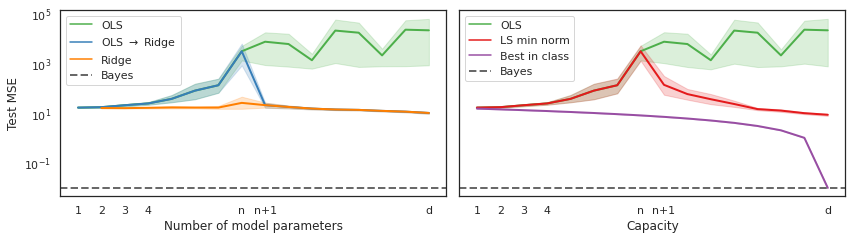

In [57]:
sns.set_style('white')
sns.set_context('notebook')

# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['ytick.left'] = True

y_var = "Test MSE"

f, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=True)

ax = axes[0]
sns.lineplot(
    data = df,
#     data=df[
#         df['Method'].isin(['OLS', r'OLS $\rightarrow$ Ridge', 'Ridge', 'OLS (min norm)', 'Best in class'])
#     ],
    x='Number of model parameters',
    y=y_var,
    ax=ax,
    linewidth=2,
    hue='Method',
    hue_order=['OLS', r'OLS $\rightarrow$ Ridge', 'Ridge'], #, 'OLS (min norm)', 'Best in class'],
    palette=['#4daf4a', '#377eb8', '#ff7f00'])

ax.set_xlabel(r'Number of model parameters')

ax = axes[1]
sns.lineplot(
    data = df,
    x='Number of model parameters',
    y=y_var,
    ax=ax,
    linewidth=2,
    hue='Method',
    hue_order=['OLS', 'LS min norm', 'Best in class'],
    palette=['#4daf4a', '#e41a1c', '#984ea3'])

ax.set_xlabel(r'Capacity')

for ax in axes:
    ax.set_xticks([1, 2, 3, 4, n, n+1, d])
    ax.set_xticklabels([1, 2, 3, 4, 'n', 'n+1', 'd'])
    ax.legend(loc="upper left")
    ax.axhline(bayes_error, ls='--', label='Bayes', c='dimgrey', linewidth=2)
    ax.legend()

plt.yscale('log')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig('./figures/regression_double_descent_informative.pdf')
plt.show()